# Hydroglaciology

## Importing modules and libraries

In [1]:
import csv
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import math
import datetime
import time
import obspy

In [2]:
from hydronoise import hydronoise_plot
from hydronoise import amp_noise_mean_median

In [3]:
from normalize import normalize

## Functions

## Importing data from gauging station and temperature

In [4]:
direct = 'D:\MEMOIRE\HYDRO'
stt_gauging = '\V550\Vdv_data_20221116122909'
stt_temp = '\V299\Vdv_data_20221120143940'

In [5]:
gauging_time = []
gauging_velos = []

with open(direct+stt_gauging+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            gauging_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            gauging_time.append(gauging_date)
            gauging_velos.append(float(row[3].replace(',','.')))
            
        line += 1

temp_time = []
temp = []

with open(direct+stt_temp+'.csv') as file :
    readcsv = csv.reader(file, delimiter=';')
    line = 0
    for row in readcsv :
        if line > 4 :
            temp_date = datetime.datetime.strptime(str(row[0]), '%Y-%m-%d %H:%M:%S')
            temp_time.append(temp_date)
            temp.append(float(row[1].replace(',','.')))
            
        line += 1

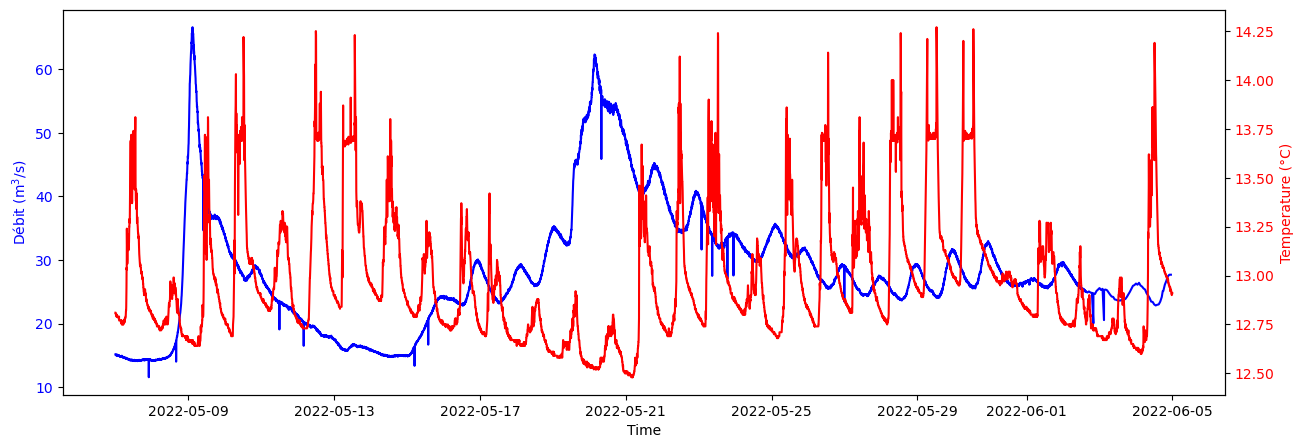

In [6]:
fig, ax1 = plt.subplots(figsize=(15,5)) 
  
ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
  
ax2.set_ylabel('Temperature (°C)', color = 'red') 
ax2.plot(temp_time, temp, label = 'Température | Station V159', c='red')
ax2.tick_params(axis ='y', labelcolor = 'red') 
 
# Show plot

plt.show()

In [7]:
n=1
max_temp = []
max_velos = []
for i in range(len(temp_time)):
    #print(i)
    if temp_time[0] == temp_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(temp[i-288:i]) + (i-288)
        max_temp.append(temp_time[idx])
        #print(i-456)
        n+= 1
        
n=1        
for i in range(len(gauging_time)):
    #print(i)
    if gauging_time[0] == gauging_time[i] - datetime.timedelta(hours=n*24) :
        idx = np.argmax(gauging_velos[i-289:i]) + (i-289)
        max_velos.append(gauging_time[idx])
        n+= 1
    
delta_time = np.subtract(max_velos, max_temp)

for i in range(len(delta_time)) :
    delta_time[i] = delta_time[i]/datetime.timedelta(hours=1)
    

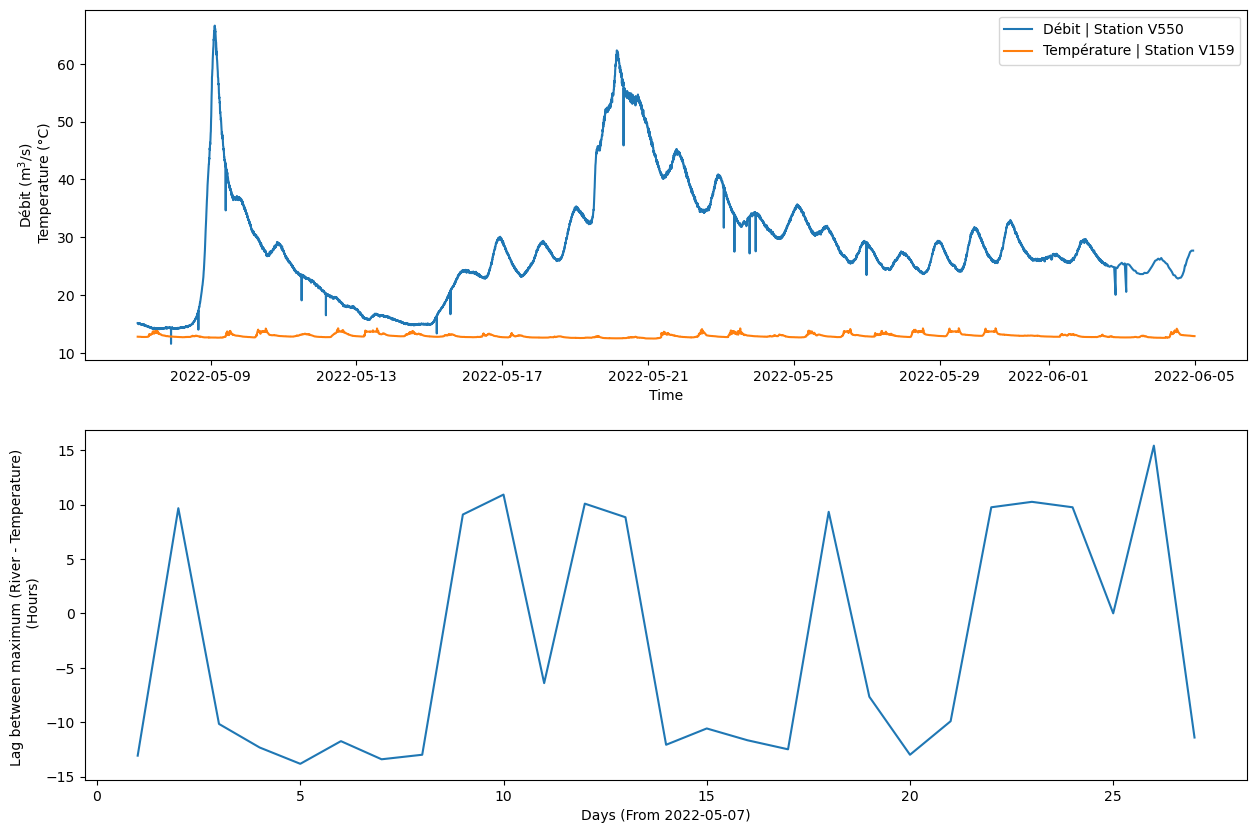

In [8]:
fig = plt.subplots(2, 1, figsize=(15, 10))
plt.subplot(2, 1, 1)


plt.plot(gauging_time, gauging_velos, label = 'Débit | Station V550')
plt.plot(temp_time, temp, label = 'Température | Station V159')
plt.xlabel('Time')
plt.ylabel('Débit (m$^3$/s) \n Temperature (°C)')
plt.legend()


plt.subplot(2, 1, 2)

day = list(range(1,28))
#plt.plot(day,max_temp.date())
#plt.plot(day,max_velos.time())
plt.plot(day, delta_time[:27])
plt.xlabel('Days (From 2022-05-07)')
plt.ylabel('Lag between maximum (River - Temperature) \n (Hours)')
plt.show()

In [9]:
file_precip = '\\PRECIP\\04176099999.csv'
starttime = '2022-05-07'
start = 0

precip_time = []
precip = []

with open(direct+file_precip) as file :
    readcsv = csv.reader(file, delimiter=',')
    line = 0
    for row in readcsv :
        if line > 0 :
            print(row[aa1])
        if line == 0 :
            aa1 = row.index('AA1')
            date = row.index('DATE')
        elif line > 0 and row[date][0:10] == starttime :
            print(row[date][0:10])
            start = 1
        elif start == 1 :
            precip_time.append(datetime.datetime.strptime(row[date],'%Y-%m-%dT%H:%M:%S'))
            precip.append(float(row[aa1][3:7]))
        line += 1


03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,0002,3,1
03,0002,3,1
03,0002,3,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,0001,3,1
03,0001,3,1
03,0001,3,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0000,9,1
03,9999,9,9
03,9999,9,9
03,0

ValueError: could not convert string to float: ''

## Confronting wave with water

### Plotting signal amplitude filter between 10-20Hz with discharge and temperature

In [42]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
#noise_time781, mean781, median781 = amp_noise_mean_median(root,'453020781.',1, '2022.05.08')
noise_time739, mean739, median739, meanall739, medianall739, theta = amp_noise_mean_median(root,'453020773.',20, '2022.05.08',2,5)



2022.05.08.00.00.00.000
Days 3 accomplished in 4.859375 seconds
2022.05.09.00.00.00.000
Days 4 accomplished in 5.5 seconds
2022.05.10.00.00.00.000
Days 5 accomplished in 5.203125 seconds
2022.05.11.00.00.00.000
Days 6 accomplished in 4.703125 seconds
2022.05.12.00.00.00.000
Days 7 accomplished in 6.390625 seconds
2022.05.13.00.00.00.000
Days 8 accomplished in 6.484375 seconds
2022.05.14.00.00.00.000
Days 9 accomplished in 6.09375 seconds
2022.05.15.00.00.00.000
Days 10 accomplished in 5.53125 seconds
2022.05.16.00.00.00.000
Days 11 accomplished in 6.0 seconds
2022.05.17.00.00.00.000
Days 12 accomplished in 5.546875 seconds
2022.05.18.00.00.00.000
Days 13 accomplished in 4.84375 seconds
2022.05.19.00.00.00.000
Days 14 accomplished in 5.6875 seconds
2022.05.20.00.00.00.000
Days 15 accomplished in 5.046875 seconds
2022.05.21.00.00.00.000
Days 16 accomplished in 4.828125 seconds
2022.05.22.00.00.00.000
Days 17 accomplished in 5.265625 seconds
2022.05.23.00.00.00.000
Days 18 accomplished in

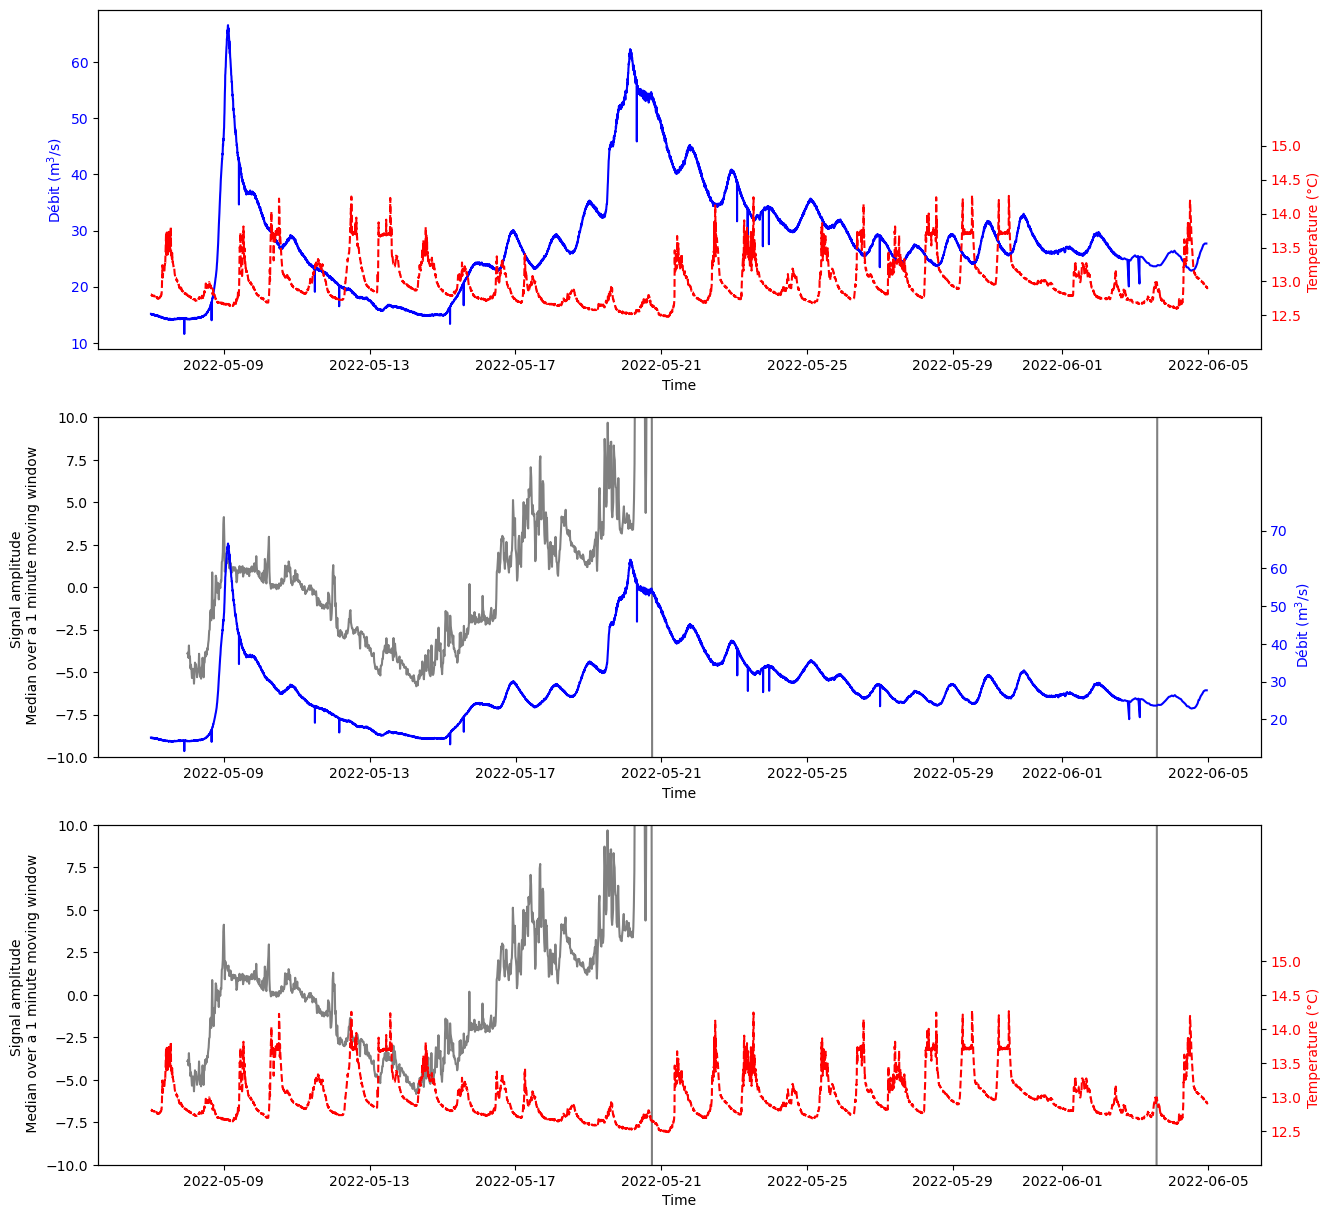

In [47]:
median739 = np.array(median739)
power = 20*np.log10(median739[:,0])
hydronoise_plot(gauging_time, gauging_velos,temp_time, temp, noise_time739, power,(-10,10))

(0.0, 25.0)

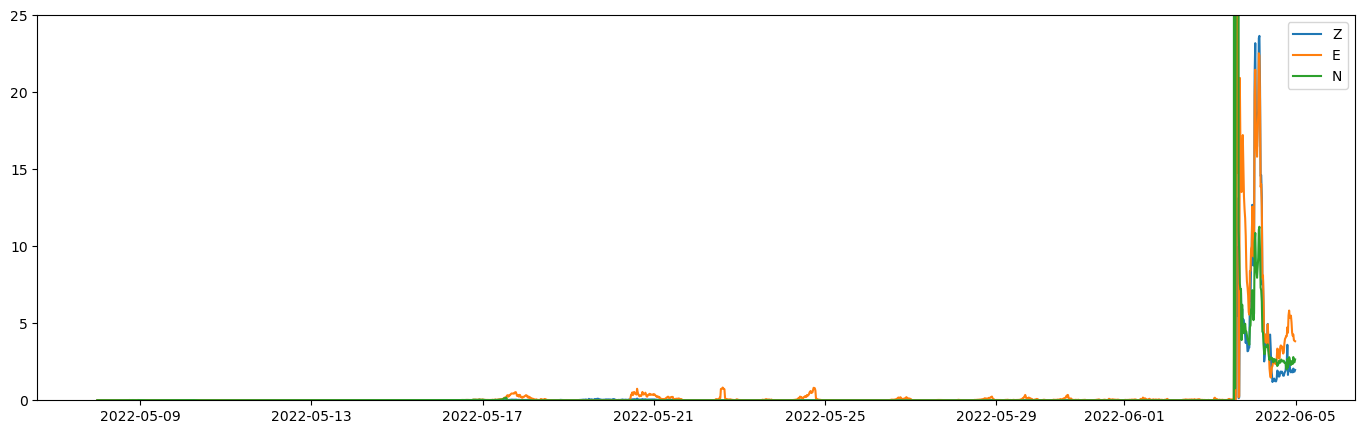

In [38]:
plt.figure(figsize=(17,5))
plt.plot(noise_time739,median739)
plt.legend(['Z','E','N'])
plt.ylim(0,25)

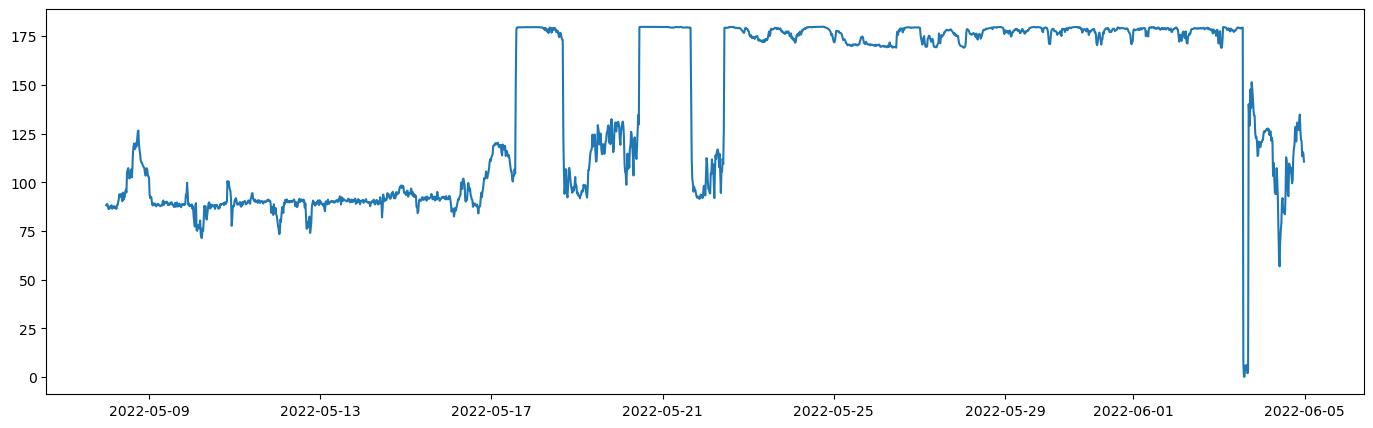

In [39]:
plt.figure(figsize=(17,5))
plt.plot(noise_time739, theta)
plt.show()

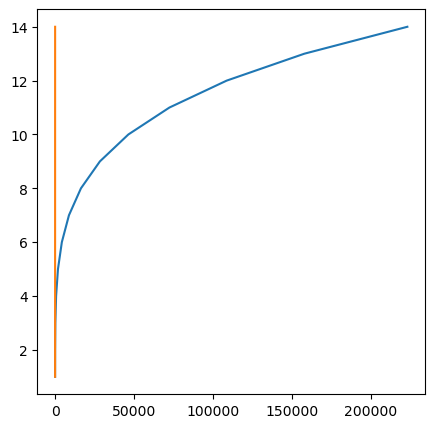

In [34]:
PEXAMP = np.array(list(range(1,15)))

QHYD = np.power(PEXAMP,(14/3))
QPRESS = np.power(PEXAMP,(5/4))

fig = plt.figure(figsize=(5,5))
plt.plot(np.log10(QHYD), PEXAMP)
plt.plot(np.log10(QPRESS), PEXAMP)
plt.show()

In [ ]:
Pw = power-np.min(power)

### Determining the periodicity of the signals
Crédit :
https://stackoverflow.com/questions/27673496/python-numpy-fft-or-rfft-to-find-period-of-a-wave-instead-of-its-frequiency

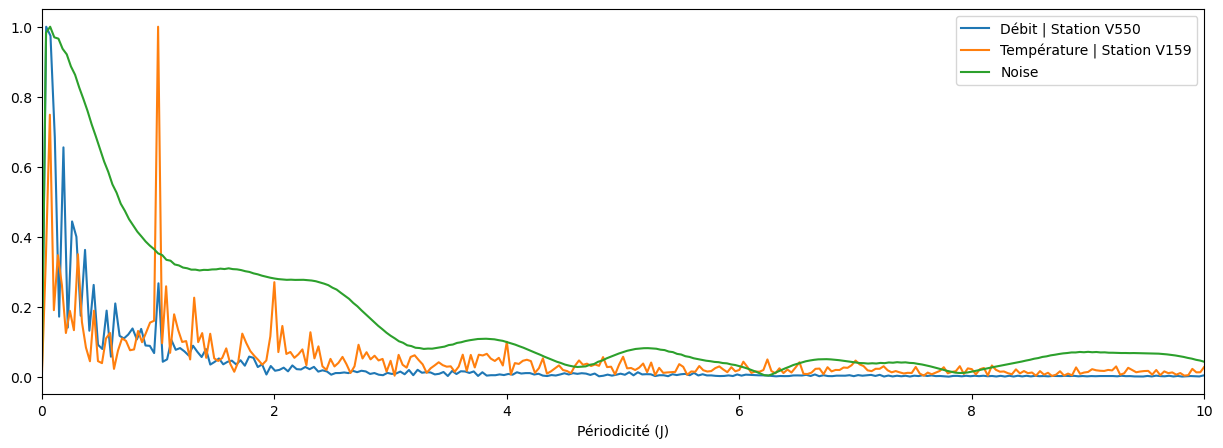

In [40]:
#sample_rate = 180
temp = np.array(temp)
amp_temp =np.abs(np.fft.rfft(temp, n=temp.size))
freq_temp = np.fft.rfftfreq(temp.size, d=1/288)
amp_temp[0] = 0
idx = amp_temp.argmax()

amp_temp = normalize(amp_temp)

gauging_velos = np.array(gauging_velos)
amp_gauging_velos =np.abs(np.fft.rfft(gauging_velos, n=gauging_velos.size))
freq_gauging_velos = np.fft.rfftfreq(gauging_velos.size, d=1/288)
amp_gauging_velos[0] = 0
idx = amp_gauging_velos.argmax()

amp_gauging_velos = normalize(amp_gauging_velos)

noise = np.array(power)
amp_noise =np.abs(np.fft.rfft(noise, n=noise.size))
freq_noise = np.fft.rfftfreq(noise.size, d=1/(24*3))
amp_noise[0] = 0
idx = amp_noise.argmax()

amp_noise = normalize(amp_noise)

fig = plt.figure(figsize=(15, 5))
plt.plot(freq_gauging_velos, amp_gauging_velos, label="Débit | Station V550")
plt.plot(freq_temp, amp_temp, label="Température | Station V159")
plt.plot(freq_noise, amp_noise, label='Noise')
plt.xlim(0,10)
plt.xlabel('Périodicité (J)')
plt.legend()
plt.show()


### Plotting from a isolated seismometer

In [ ]:
def perm_amp_noise_mean_median(window_size, startdate) :
    
    root = "D:\\permanent\\kal\\HHZ.D\\"

    startdate = datetime.datetime.strptime(startdate, '%Y.%m.%d')
    daynumber = startdate - datetime.datetime.strptime('2022.01.01', '%Y.%m.%d')
    daynumber = int(daynumber.total_seconds()/(24*60*60))

    startnumber = 3
    days = 31 - startnumber

    median = []
    mean = []

    for day in range(days) :
        start = time.process_time()
        date = startdate + datetime.timedelta(days = day)
        datetimeStr = date.strftime("%Y.%m.%d.%H.%M.%S.000")
        print(datetimeStr)
        trace = obspy.read(root+'VI.kal..HHZ.D.2022.'+str(daynumber))
        if day == 0 :
            starttime = str(trace[0].stats.starttime)
            starttime = datetime.datetime.strptime(starttime, '%Y-%m-%dT%H:%M:%S.020000Z')
            noise_time = [starttime]

        window = 24*60/window_size

        trace = np.array(trace[0])

        trace = np.abs(trace)


        npts_p_min = int(len(trace)/(24*60))


        for i in range(int(window)) :
            t0 = i*npts_p_min
            t1 = npts_p_min + i*npts_p_min
            array = trace[t0:t1]
            mean.append(np.mean(array))
            median.append(np.median(array))
            if i > 0 and day == 0 :
                noise_time.append(noise_time[i-1]+datetime.timedelta(minutes=window_size))
            elif day > 0 :
                base = int(day*window)
                noise_time.append(noise_time[base+i-1]+datetime.timedelta(minutes=window_size))
        end = time.process_time() 
        print('Days '+str(day+startnumber)+' accomplished in '+str(end-start)+' seconds')
    return noise_time, mean, median

In [ ]:
noise_timekal, meankal, mediankal = perm_amp_noise_mean_median(60, '2022.05.08')

In [ ]:
hydronoise_plot(gauging_time, gauging_velos,temp_time, temp, noise_timekal, mediankal,(9860,9950))

In [ ]:
root = "D:\\Nodes_ablation_zone\All_comp_DP_\\"
p = obspy.read(root+'453020773.3.2022.05.08.00.00.00.000.Z.miniseed')
p[0].stats

In [ ]:
p.spectrogram(log=True, title='SS_2O781')

# Garbage

In [ ]:
max_velos = np.amax(gauging_velos)
min_velos = np.amin(gauging_velos)
normalise_velos = (gauging_velos - min_velos)/(max_velos-min_velos)*1000

max_temp = np.amax(temp)
min_temp = np.amin(temp)
normalise_temp = (temp - min_temp)/(max_temp-min_temp)*500

fig = plt.subplots(3, 1, figsize=(15, 15))
ax1 = plt.subplot(3, 1, 1)


ax1.set_xlabel('Time') 
ax1.set_ylabel('Débit (m$^3$/s)', color = 'blue') 
ax1.plot(gauging_time, gauging_velos, label = 'Débit | Station V550', c='blue')
ax1.tick_params(axis ='y', labelcolor = 'blue') 
  
# Adding Twin Axes

ax2 = ax1.twinx() 
    
ax2.set_ylabel('Temperature (°C)'+24*' ', color = 'red')
ax2.set_ylim((12,17))
ax2.set_yticks([12.5,13,13.5,14,14.5,15])
ax2.plot(temp_time, temp, label = 'Température | Station V159', c='red', linestyle='--')
ax2.tick_params(axis ='y', labelcolor = 'red') 


plt.subplot(3, 1, 2)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(gauging_time,normalise_velos, label = 'Débit normalise 0-1000 | Station V550', c='darkgreen')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.subplot(3, 1, 3)

#plt.plot(noise_time773,median773, label='SS_20773')
plt.xlim((temp_time[0],temp_time[len(temp_time)-1]))
plt.ylim((0,1500))
plt.plot(noise_time739,median739, label='SS_20739')
plt.plot(temp_time,normalise_temp, label = 'Temperature normalise 0-500 | Station V159', c='red',linestyle='dashed')
plt.xlabel('Time')
plt.ylabel('Signal amplitude \n Median over a 1 minute moving window')

plt.legend()

plt.show()

